# The Finite Element Method

The Finite Element Method (FEM) is a very popular method with a wide range of applications. It is an *integral* technique, similar to the Finite Volume Method which provide it with a number of benefits.  

* Complex geometries
* Irregular meshing
* Irregular material properties
* Options to tweak the method according to the physics
* (quasi)dynamic mesh refinement
* Highly flexible boundary conditions
* Ability to solve *boundary physics*
* Excellent accuracy

## Illustrative example

Consider an ODE $ y^\prime = -y \quad y(0) = 1$, which has an analytical answer $y = e^{-t}$.

We wish to approximate this function numerically between $[0,1]$ with a line defined by the boundary points, $f(0) = a = 1$ and $f(1) = b$, $$f(x) =  [1-x] + x b$$

How do we find $b$?

### Option 1: Direct substitution

Following the Finite Difference method, we can subsitute $f(1)$ into the ODE and solve for b:

$$\begin{align}
f'(1) &= f(1) \\
b-1 &= -b \\
b &= 1/2
\end{align}$$
and the approximate solution is $f = 1 -\frac{x}{2}$



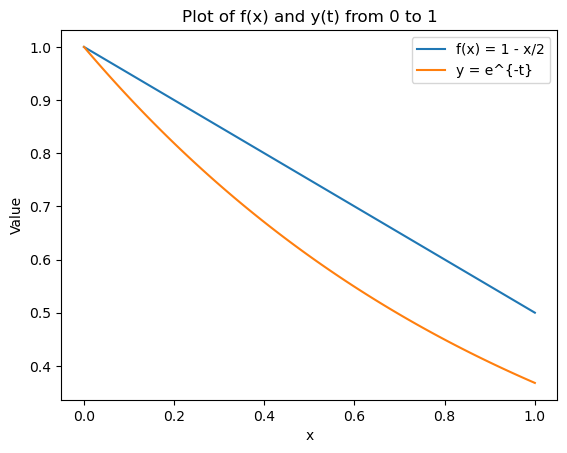

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the functions
f = lambda x: 1 - x / 2
y = lambda t: np.exp(-t)

# Generate values
x = np.linspace(0, 1, 100)
f_values = f(x)
y_values = y(x)

# Plot the functions
plt.plot(x, f_values, label='f(x) = 1 - x/2')
plt.plot(x, y_values, label='y = e^{-t}')
plt.xlabel('x')
plt.ylabel('Value')
plt.legend()
plt.title('Plot of f(x) and y(t) from 0 to 1')
plt.show()

### Option 2: Least square minimization of the residual

Let's integrate the squared residual of f(x) plugged into the ODE, $y^\prime + y$

$$\begin{align}
R &= f^\prime(x) +f(x) \\
&= [b-1] + 1-x + x b \\
&= b+x[b-1] \\
R^2 &= b^2 + 2 b x[b - 1] + [x[b - 1]]^2 \\
F = \int_0^1 R^2 \ dx &= \frac{1}{3} [7 b^2 - 5 b + 1] \\
\end{align} $$

Note that in the end the integral of the residual, $F$ is a parabolic function of the parameter $b$. The minimum is found at:
$\frac{\partial F}{\partial b}(b) = 0, for $b = \frac{5}{14}$. The approximate solution is $f(x) = 1-\frac{9}{14}x$.

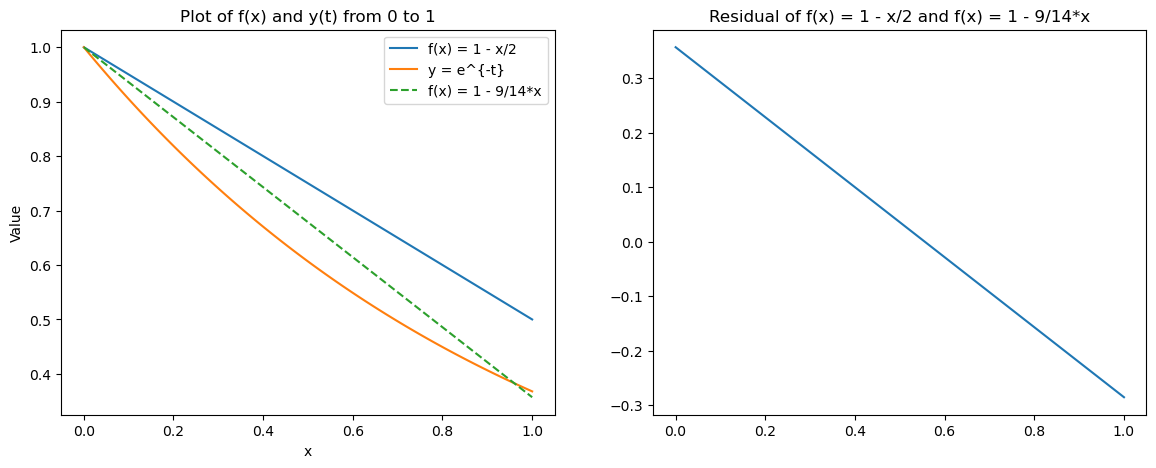

In [ ]:
# Define the new function
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
f_new = lambda x: 1 - 9./14*x
f_new_values = f_new(x)


# Plot the functions
axs[0].plot(x, f_values, label='f(x) = 1 - x/2')
axs[0].plot(x, y_values, label='y = e^{-t}')
axs[0].plot(x, f_new_values, label='f(x) = 1 - 9/14*x', linestyle='--')
axs[0].set_xlabel('x')
axs[0].set_ylabel('Value')
axs[0].legend()
axs[0].set_title('Plot of f(x) and y(t) from 0 to 1')

# Plot the residual
residual = lambda x: -9/14 + 1 - 9./14*x
axs[1].plot(x, residual(x))
axs[1].set_title('Residual of f(x) = 1 - x/2 and f(x) = 1 - 9/14*x')

plt.show()

We see that option 2 does a better job of approximating the function over the full domain since it focusses on the integral of the residual.

You may have noticed that we did something funny here: we integrated $R^2$ and then took its derivative with respect to $b$ in order to find the minimum of the integral! I.e.:

$$\begin{align}
\frac{\partial F}{\partial b} = 0 &= \frac{\partial }{\partial b} \int_0^1 R^2 \ dx  \\
&= \int_0^1 R \frac{\partial R}{\partial b}  \ dx \\
&= \int_0^1 R W  \ dx
\end{align} $$

where the residual has now been weighted by the function $W$. This is called the Method of Weighted Residual [MWR]. Let's try a different function and see what happens.

### Option 3: Integrate the MWR to find the parameters

Integrate the weighted residual function directly with a convenient choice of $W$.

lets take $W = x$ (to be motivated later) and integrate:

$$\begin{align}
\frac{\partial F}{\partial b} =0 &= \int_0^1 R x  \ dx \\
&= \int_0^1 \big[b+[b-1]x\big]x  \ dx \\
&= \int_0^1 b x+[b-1]x^2  \ dx \\
&= \bigg[ \frac{1}{6} x^2\big[3b+2[b-1]x\big]\bigg]_0^1 \\
&= b-\frac{2}{5} \\
\end{align} $$

which is very close to our previous solution $b = \frac{5}{14}$ but with a simpler integration. BUT, we are still let with analytically integrating! If only there were a way to express integrals as the sum of the integrand evaluated at certain points...

### Option 4: Express the MWR integral as the sum of the integrand evaluated at certain points.

Integrate the weighted residual function directly with a convenient choice of $W$ as the sum of the integrand evaluated at certain points:

Recall Gaussian Quadrature allows us to evaluate an integral by summing the integrand at the Gauss Points. The Gauss Points for the domain $[-1,1]$ are $\pm\frac{1}{\sqrt{3}}$, scaled to this integral domain become,


$$ \begin{align}
x_{[0,1]]} &= 0.5 (x_{[-1,1]} + 1) \\
&= \frac{1}{2} \bigg[1 \pm\frac{1}{\sqrt{3}} \bigg] \\
&\approx [0.21132487, 0.78867513]
\end{align} $$

and

$$\begin{align}
0 &= \int_0^1 R x  \ dx \\
&= Rx (x=.21132487) + Rx(x = .78867513) \\
&= -0.0446582 + 0.255983 b  -0.622008 + 1.41068 b \\
b &= \frac{2}{5}
\end{align} $$

### Recap of the approach

Let's recap what we've done:

1. parameterized a function as a weighted sum of simpler functions (a linear basis)
2. found a (simple) integral expression that minimizes the error in the approxiation (Minimized Weighted Residual)
3. performed the integration *exactly* using only function evaluations into a linear system (Gaussian quadrature)
4. Solved the linear system (I **told** you everything boiled down to linear systems!)

Practical solution of linear systems requires sparsity! Let's formalize our proceedure and see how we can ensure sparsity.

## Derivation of the finite element method BVPs

Consider a linear differential equation,
$$ \mathcal{L}(u) = f \quad \text{in } \Omega, $$

in one dimension for convenience.

** Boundary conditions in $\partial \Omega$?

where:
* $\mathcal{L}$ is a differential operator
* $u(x)$ is the unknown *exact* solution
* $f(x)$ is a given source term dependant only on space.
* $\Omega$ is the ND domain of the problem, with boundary $\partial \Omega$.

Define the residual,
$$ R(u) = \mathcal{L}(u) - f$$
For the exact solution, $R(u) = 0$ everywhere in $\Omega$.

### Approximate the solution with *shape functions*

In liue of an exact solution, we will have to settle for an approximate solution, $u_h$, for which $R(u_h) \ne 0$ but will be made as small as possible. As discussed in the Interpolation sections, a function can be approximated as a weighted sum of basis functions:

$$ \begin{align}
u_h(x) &= \sum_{i=1}^N w_i \phi_i(x) \\
\end{align}$$

Where:
* $w_i$ are the weights / coefficients of the approximation
* $\phi_i(x)$ are a set of suitable *shape functions*.

It is trivial to see that,
$$ \nabla u_h = \sum_i w_i \nabla \phi_i $$

### Minimizing the residual with the *Method of Weighted Residuals*

The best approximation will minimize the residual everywhere in $\Omega$. In previous work (e.g.: curve fit) we minimzed the square of the residual, but here we will use the Method of Weighted Residuals:

$$ \int_\Omega R v \  dx = 0 $$

The MWR is a *weaker* statement of minimization.
$v(x)$ is a *test* function for which we have options.


#### $v = \frac{\partial R}{\partial w_i}$ : Least Squares

If we take $v = \frac{\partial R}{\partial w_i}$,

$$ \begin{align}
\int_\Omega R \frac{\partial R}{\partial w_i} d\Omega &= 0 \\
\frac{\partial }{\partial w_i} \int_\Omega R^2 d\Omega &= 0
\end{align}$$

which is exactly the condition for finding the parameters for Least Squares minimization.

#### $v = \delta (x) $: Collocation methods

If $v = \delta (x)$ then for a discrete set of points $x_i$, the integral turns into a sum:

$$ \begin{align}
\int_\Omega R \delta(x_i) d\Omega &= 0 \\
\sum_i R(x_i) = 0
\end{align}$$

which requires that the residual be zero at all discretization points (the collocation method).

#### $v = \sum_i \phi_i$: The Galerkin method

The Galerkin method chooses the test functions to be in the same basis as the solution $u_h = \sum_i w_i \phi_i$.

$$ \begin{align}
\int_\Omega R v \  d\Omega &= 0 \\
\sum_i \int_\Omega R \phi_i \  d\Omega &= 0
\end{align}$$

Why does this work? Note that the MWR is an expression of orthogonality between $R$ and $v$. What this means is that the residual has no component in the space defined by the basis functions, or more simply, it can't be improved by changing the weights $w_i$. This is a more general expression for the minimum which is more in line with our discrete / numerical approach. It also opens avenues to choose $\phi_i$ carefully for computational efficiency!



### The weak form

Our usual formulation of BVPs is called the *strong* form because it assumes a lot of continuity in a solution. E.g.: if the equation contains $\nabla^2 u$, the solution assumes that that derivative exists!

The MWR leads to the *weak form* which has less requirements on the solution, amoungst other benefits. Essentially, all we have to do is multiply through by our test function $v$ and integrate. Something *very* useful happens to our divergence-of-flux terms, which are prevelant in conservation equations.

As an example, consider a time dependant heat balance (temperature = $u$), using the backward Euler time marching scheme.
$$ \begin{align}
\frac{\partial u}{\partial t} &= -\nabla \cdot \vec{J} \\
\frac{u - u^{t-1}}{\Delta t} &= -\nabla \cdot \vec{J} \\
u + \Delta t [\nabla \cdot \vec{J}] &= u^{t-1}
\end{align}$$


To get to the weak form, multiply through by the test funciton $v$ and integrate:  

$$ 0 = \int_{\Omega} u v - \int_{\Omega} u^{t-1}v \  + \Delta t \int_{\Omega}v \nabla \cdot \vec{J} $$

Examining the divergence-of-flux term, we see that we can apply integration by parts followed by the Divergence Theorem:
$$ \begin{align}
\int_\Omega v \nabla \cdot \vec{J}  &= -\int_\Omega \nabla v \cdot \vec{J}  + \int_{\Omega} \nabla \cdot \big[v\vec{J}\big]  \\
&=-\int_\Omega \nabla v \cdot \vec{J}  + \int_{\partial \Omega} v \ \vec{J} \cdot \hat{n} \\
&=\int_\Omega \lambda \nabla v \nabla u  + \int_{\partial \Omega} v \ \vec{J} \cdot \hat{n}    
\end{align}$$

which is remarkable since we:

* replaced a second derivative with the product of two first derivatives.
* no longer require our solution to *have* a second derivative (it can be less smooth and satisfy the equation in an average sense which is *weaker* than the *strong* form)!
* incorporated boundary fluxes directly into the residual calculation (through the surface integral)
* do not require anything from $\lambda$, which means this is still valid for $\lambda(u,x,t...)$, however it is now outside of the gradient!
* We also provided an avenue for directly integrating surface *phenomena* into our model through the surface integral!)




The weak form of the equation becomes (collecting all unknowns on the fight hand side),

$$ \begin{align}
\int_{\Omega} u v + \Delta t \int_\Omega \lambda \nabla v \nabla u   + \Delta t \int_{\partial \Omega} v \ \vec{J} \cdot \hat{n} &= \int_{\Omega} u^{t-1}v \\
\end{align}$$




## Discretization

We are now in a position to discretize the equation into a form we are able to solve, which will (finally) give us an idea of what the shape functions are.

### Meshing the domain

The geometry of the problem can generally be complex, with curved boundaries separating adjacent domains. Additionally, we may want different spatial resolution at different points in our model to capture gradients or differeing material properties.

The Finite Element Method partitions the domain into a *Finite* set of *Elements* through tesselation (space filling tiling). This meshing proceedure is actually very complex and there are sophisticated, dedicated software packages e.g., Cubit  (commercial), GMSH (open source), etc.

The most flexible element in 2D is triangular, but quadralateral elements are also popular. In 3D, tetrahedra are common, triangular prisms or rectangular prisms are also admissable.

Elements may be mixed to better capture features. E.g.: in Computational Fluid Dynamics one may use square boundary layers along a surface and then triangles in the stream.

One does have to be wary of degeneracy where one side is small compared to the others, which can lead to poor numerical performance.


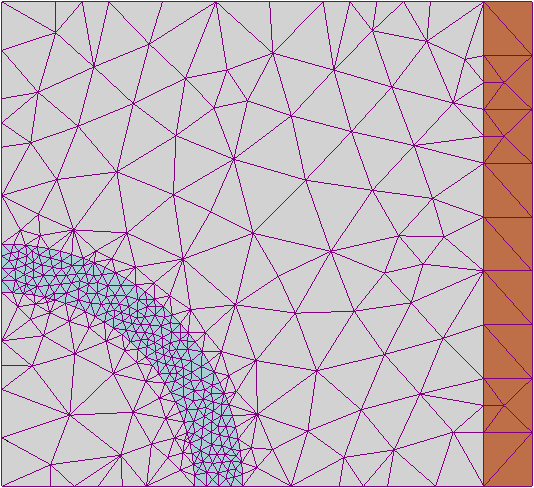

Notice how each mesh cell is a scaled, translated version of the same reference cell.

## Shape functions


Shape functions are generally chosen to approximate the (unknown) function *on each element*.

The choice of element type determines:
* the *nodes* - the points within the element at which the degrees of freedom are specified.
* the function which approximates the solution on the element.
* the meaning of the degrees of freedom (function values or derivatives at the nodes?)
* the continuity of the quantity between elements.

#### Lagrange elements


A general purpose basis though is our good, old LaGrange interpolation functions taken piecewise over the elements! These functions have nodes at the verticies of the mesh (at least), at which the value of the function is specified.

The shape funciton is zero at every node except the one it is associated with:

$$\phi_i(x_j) = \delta_{ij}$$

The first three orders (in 1D) are:


| **Order** | **Node** ................   | **Basis Function**......................................                                    |
|-----------|-----------------------|------------------------------------------------------|
| Zeroth    | $x_0 = 0$             | $\phi_0(x) = 1$                                      |
| First     | $x_0 = 0$             | $\phi_0(x) = 1 - x$                                  |
|           | $x_1 = 1$             | $\phi_1(x) = x$                                      |
| Second    | $x_0 = 0$             | $\phi_0(x) = 2(1 - x)(0.5 - x)$                      |
|           | $x_1 = 0.5$           | $\phi_1(x) = 4x(1 - x)$                              |
|           | $x_2 = 1$             | $\phi_2(x) = 2x(x - 0.5)$                            |
| Third     | $x_0 = 0$             | $\phi_0(x) = -9/2 (x - 1/3)(x - 2/3)(x - 1)$         |
|           | $x_1 = 1/3$           | $\phi_1(x) = 27/2 x(x - 2/3)(x - 1)$                 |
|           | $x_2 = 2/3$           | $\phi_2(x) = -27/2 x(x - 1/3)(x - 1)$                |
|           | $x_3 = 1$             | $\phi_3(x) = 9/2 x(x - 1/3)(x - 2/3)$                |


In [1]:
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact

import matplotlib.pyplot as plt

# Define Lagrange basis functions for each order
def lagrange_basis(order, x, node):
    """
    Compute the Lagrange basis function for a given node and order.

    Args:
    - order: Order of the Lagrange polynomial (0, 1, 2, 3).
    - x: The points where the function is evaluated (numpy array).
    - node: The index of the current basis function (0, 1, ..., order).

    Returns:
    - The values of the Lagrange basis function at points `x`.
    """
    nodes = np.linspace(0, 1, order + 1)
    basis = np.ones_like(x)
    for j in range(order + 1):
        if j != node:
            basis *= (x - nodes[j]) / (nodes[node] - nodes[j])
    return basis

# Function to plot the Lagrange basis functions
def plot_lagrange_basis(order):
    x = np.linspace(0, 1, 500)  # Points to evaluate the basis functions
    colors = ['blue', 'green', 'orange', 'red']  # Colors for each order
    plt.figure(figsize=(10, 8))
    nodes = np.linspace(0, 1, order + 1)
    for node in range(order + 1):
        y = lagrange_basis(order, x, node)
        plt.plot(x, y, label=f"Node {node}")
        plt.scatter(nodes[node], 1, color=colors[order % len(colors)], zorder=5)
    plt.title(f"Lagrange Basis Functions of Order {order}")
    plt.xlabel("x")
    plt.ylim([-.4, 1.2])
    plt.ylabel("Basis Function Value")
    plt.legend(loc='best', fontsize=8)
    plt.grid(True)
    plt.show()

# Create an interactive slider for the order
interact(plot_lagrange_basis, order=widgets.IntSlider(min=0, max=3, step=1, value=0))

interactive(children=(IntSlider(value=0, description='order', max=3), Output()), _dom_classes=('widget-interac…

<function __main__.plot_lagrange_basis(order)>

Linear Lagrange elements in 1D form *tent* functions,

$$ \phi(x) = \begin{cases} 1 - |x| & \text{if } |x| \leq 1 \\ 0 & \text{otherwise} \end{cases} $$

an example of reconstruction of a function is the Bessel Function

Linear_interpolation_of_J0_(basis_set).svg

the benefit of this is that $\int \phi_i \phi_j$ = 0 and $\int \nabla \phi_i \nabla \phi_j$ =0 for almost all combinations of i  and j!